In [1]:
import numpy as np 
import tensorflow as tf
import pandas as pd 
from matplotlib import pyplot as plt
from imblearn.over_sampling import RandomOverSampler 
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from keras.layers.merge import concatenate
import PIL

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cancer_type = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:
classes = {0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  
           1:('bcc' , ' basal cell carcinoma'), 
           2 :('bkl', 'benign keratosis-like lesions'), 
           3: ('df', 'dermatofibroma'),
           4: ('nv', ' melanocytic nevi'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'), 
           6: ('mel', 'melanoma')}

In [5]:
dataset = pd.read_csv('gdrive/Shareddrives/FIT3163 - Group 6 Assignment/CNN/hmnist_28_28_RGB.csv')# pixel detail
metadata = pd.read_csv("gdrive/Shareddrives/FIT3163 - Group 6 Assignment/CNN/HAM10000_metadata.csv")

In [6]:
# 'label' is the result,drop first
image_data = dataset.drop(['label'], axis = 1)
image_data = np.array(image_data)
# the number of images,reshape
image_index = len(dataset.index)
images = image_data.reshape(-1, 28, 28,3)
image_label = metadata['dx']

In [7]:
data_wt_lable = dataset.drop(['label'], axis = 1)

In [8]:
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(data_wt_lable,dataset['label'])
x = np.array(x).reshape(-1,28,28,3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [9]:
# split into train and test data
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y,test_size=0.2, random_state = 8)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_val, y_train_val, test_size = 0.25, random_state = 8 ) 

In [10]:
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_valid_mean = np.mean(x_valid)
x_valid_std = np.std(x_valid)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_valid = (x_valid - x_valid_mean)/x_valid_std
x_test = (x_test - x_test_mean)/x_test_std

In [11]:
# regenerating image to expand the training set
img_generate =ImageDataGenerator(rotation_range=15, # rotate the image 15 degrees
                               shear_range=0.1, # cutting away part of the image (max 10%)
                               zoom_range=0.05, # Zoom in by 5% max
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='nearest')
# add the generated images into the training set
img_generate.fit(x_train)

In [12]:
# regenerating image to expand the training set
img_generate2 =ImageDataGenerator(rotation_range=90, # rotate the image 15 degrees
                               shear_range=0.1, # cutting away part of the image (max 10%)
                               zoom_range=0.05, # Zoom in by 5% max
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='nearest')
# add the generated images into the training set
img_generate2.fit(x_train)

In [15]:
# define CNN model 
def cnn():
  # input layer
  inputs = Input(shape=[28, 28,3])
  # first feature extractor
  conv1 = Conv2D(32, kernel_size=4, activation='relu')(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  Batch1= BatchNormalization()(pool1)
  flat1 = Flatten()(Batch1)
  # second feature extractor
  conv2 = Conv2D(16, kernel_size=8, activation='relu')(inputs)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  Batch2= BatchNormalization()(pool2)
  flat2 = Flatten()(Batch2)
  # merge 
  merge = concatenate([flat1, flat2])
  # interpretation 
  hidden1 = Dense(64, activation='relu')(merge)
  hidden2 = Dense(64, activation='relu')(hidden1)
  aviod_overfitting = Dropout(0.4)(hidden2)
  # prediction output
  output = Dense(7, activation='softmax')(aviod_overfitting)
  model = Model(inputs=inputs, outputs=output)

  return model

In [16]:
model = cnn()

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 25, 25, 32)   1568        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 21, 21, 16)   3088        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 12, 12, 32)   0           conv2d[0][0]                     
______________________________________________________________________________________________

In [18]:
# shuffle = True ? 
model.compile(optimizer= 'adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])
training = model.fit(x_train, y_train, epochs = 6, validation_data=(x_valid, y_valid),batch_size= 128, shuffle = True)

Epoch 1/6
221/221 [==============================] - 33s 144ms/step - loss: 1.1088 - accuracy: 0.5950 - val_loss: 0.8837 - val_accuracy: 0.7013
Epoch 2/6
221/221 [==============================] - 31s 142ms/step - loss: 0.5761 - accuracy: 0.7923 - val_loss: 0.4883 - val_accuracy: 0.8260
Epoch 3/6
221/221 [==============================] - 32s 143ms/step - loss: 0.3993 - accuracy: 0.8532 - val_loss: 0.3858 - val_accuracy: 0.8652
Epoch 4/6
221/221 [==============================] - 32s 144ms/step - loss: 0.3812 - accuracy: 0.8612 - val_loss: 0.2301 - val_accuracy: 0.9177
Epoch 5/6
221/221 [==============================] - 32s 145ms/step - loss: 0.2224 - accuracy: 0.9169 - val_loss: 0.2182 - val_accuracy: 0.9219
Epoch 6/6
221/221 [==============================] - 32s 144ms/step - loss: 0.1859 - accuracy: 0.9313 - val_loss: 0.1955 - val_accuracy: 0.9298


In [ ]:
# model.compile(optimizer= 'adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])
# # training = model.fit(x_train, y_train, epochs = 5, batch_size= 128, validation_data=(x_valid, y_valid), shuffle = True)
# training = model.fit(x_train, y_train, epochs = 10, validation_data=(x_valid, y_valid),batch_size= 128, shuffle = True)
# training = model.fit(img_generate.flow(x_train, y_train, batch_size=32),
#                    steps_per_epoch=len(x_train) / 32, validation_data=(x_valid, y_valid),epochs=15)

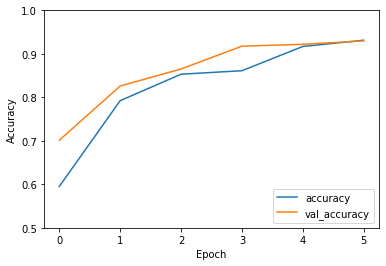

294/294 - 3s - loss: 0.1998 - accuracy: 0.9330


In [19]:
plt.plot(training.history['accuracy'], label='accuracy')
plt.plot(training.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

In [20]:
print(test_acc)

0.9329924583435059


In [21]:
model.save('gdrive/Shareddrives/FIT3163 - Group 6 Assignment/CNN/test_functional.h5')